In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
class sample_random_balls(object):
    
    def __init__(self, n_centers, var_x = 1, var_y = 1, var_xy = 0, x_range = [-10, 10], y_range = [-10, 10], rotate = False):
        """
        Want to sample K blobs, with n_points per blob. Diversity range is controlled by x_range and y_range
        """
        
        self.n_centers = n_centers
        self.covariance = np.array([[var_x, var_xy], 
                                    [var_xy, var_y]])
        
        self.x_centers = np.random.random_sample(n_centers) * (x_range[1] - x_range[0]) + x_range[0]
        self.y_centers = np.random.random_sample(n_centers) * (y_range[1] - y_range[0]) + y_range[0]
        
        self.mu = np.vstack([self.x_centers, self.y_centers]).T
    
    def sample(self, n_points):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        eig_vals, eig_vect = np.linalg.eig(self.covariance)
        
        if np.sum(eig_vals > 0) == 2:
            print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(self.covariance)
            
        elif np.sum(eig_vals >= 0) == 2:
            print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        
        point_samples = np.random.randint(low = 0, high = self.n_centers, size = n_points)
        
        z = np.random.randn(n_points, 2)
        x = self.mu[point_samples, :] + np.dot(A, z.T).T
        
        return x, point_samples

In [163]:
class k_means(object):
    def __init__(self, n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001, verbose = 0, random_state = None, copy_x = True, algorithm = 'auto'):
        
        self.n_clusters = n_clusters #number of clusters to initialise
        self.init = init #'k-means++' selects initial clusters intelligently. 'random' chooses n_clusters rows at random
        self.n_init = n_init #Number of time the k-means algorithm will be run with different centroid seeds.
        self.max_iter = max_iter #max iterations for a single run
        self.tol = tol #Relative tolerance with regards to Frobenius norm of the difference in the cluster centers
        #of two consecutive iterations to declare convergence.
        self.verbose = verbose #If verbose = 1, print loss over iterations
        self.random_state = random_state #Determines random number generation for centroid initialisation
        self.copy_x = copy_x #Will not modify the original data, if False, data is centered and then uncentered
        self.algorithm = algorithm #EM or elkan
        
        if random_state is not None:
            np.random.RandomState(self.random_state)
        
        #initialised parameters
        #self.cluster_centers_ = None #coordinates of cluster centers.
        #self.labels_ = None #labels of each point
        #self.inertia_ = None #sum of squared distances of samples to their closest center, weighted by sample weights if required
        self.inertia_train_ = None #List of inertia over the optimal run
        self.n_iter_ = None #Number of iterations runs
    
    def label_data(self, X, save_flag = True):
        N = X.shape[0]
        labels = []
        for i in range(N):
            mse = np.sum((self.cluster_centers_ - X[i, :])**2, axis = 1)
            labels.append(np.argmin(mse))
        
        if save_flag:
            self.labels_ = np.array(labels)
            
        else:
            return labels
    
    def compute_centroids(self, X):
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
            
            new_centers[k, :] = np.mean(X[label_indices, :], axis = 0)
        
        tol = np.linalg.norm(self.cluster_centers_ - new_centers)
        
        self.cluster_centers_ = new_centers

        return tol
        
    def calculate_inertia(self, X):
        
        J = 0
        
        for k in range(self.n_clusters):
            label_indices = np.nonzero(self.labels_ == k)[0]
        
            for i in label_indices:
                J += np.sum((self.cluster_centers_[k, :] - X[i, :])**2)
        
        self.inertia_ = J
    
    def initialise_centroids(self, X):
        
        if self.init == 'k-means++':
            print("Initialisation not implemented.")
            raise SystemExit
        
        elif self.init == 'random':
            
            points = np.random.randint(0, X.shape[0], self.n_clusters)
            self.cluster_centers_ = X[points, :]
        
        else:
            print("Illegal initialisation.")
            raise SystemExit
    
    def standardise(self, X):
        self._mu_ = np.mean(X, axis = 0)
        self._std_ = np.std(X, axis = 0)
        
        return (X - self._mu_) / self._std_
    
    def unstandardise(self, X):
        
        return (X * self._std_) + self._mu_
        
    def fit(self, X, sample_weights = None):
        
        #Check to see if you must standardise
        if not self.copy_x:
            X = self.standardise(X)
        
        #initialise centroids
        self.initialise_centroids(X)
        
        #Initialise iteration dictionary
        iter_dict = {}
        
        #Initialise location properties
        optimal_inertia = np.inf
        optimal_outer = None
        
        #Calculate initial inertia
        self.label_data(X)
        self.calculate_inertia(X)
        
        for outer_iter in range(self.n_init):
            
            local_inertia_list = []
            
            tol = np.inf
            cnt = 0
            while cnt < self.max_iter or tol > self.tol:
                
                #E step
                self.label_data(X)
                #print(self.labels_)
                
                #M step
                tol = self.compute_centroids(X)
                
                #Calculate loss
                self.calculate_inertia(X)
                
                #Finalise iteration
                local_inertia_list.append(self.inertia_)
                cnt += 1
            
            iter_dict[str(outer_iter)] = {"centers":self.cluster_centers_,
                                          "labels":self.labels_,
                                          "loss_list":local_inertia_list,
                                          "n_iters":cnt}
            
            if optimal_inertia > self.inertia_:
                optimal_inertia = self.inertia_
                optimal_outer = outer_iter
        
        #Load in optimal clusters
        self.cluster_centers_ = iter_dict[str(optimal_outer)]["centers"]
        
        #Label data
        self.labels_ = iter_dict[str(optimal_outer)]["labels"] #Will create a disjoint if it terminates early
        
        #Store loss list
        self.inertia_train_ = iter_dict[str(optimal_outer)]["loss_list"]
        
        #Check to see if you must un-standardise
        if not self.copy_x:
            X = self.unstandardise(X)
            self.cluster_centers = self.unstandardise(self.cluster_centers)
    
    def predict(self, X, sample_weight = None):
        labels = self.label_data(X, save_flag = False)
        
        return labels
    
    def fit_predict(self, X, sample_weight = None):
        self.fit(X, sample_weights)
        labels = self.label_data(X, save_flag = False)
        
        return labels
    
    def fit_transform(self, X, sample_weight = None):
        self.fit(X, sample_weights)
        X_new = self.transform(X)
        
        return X_new
    
    def score(self, X, sample_weight = None):
        pass

    def transform(self, X): #transform X to a cluster-distance space
        
        return X_new
    

In [95]:
a = np.random.randint(0, 5, 100)

np.nonzero(a == 0)[0]

a = np.array([1, 2, 3, 4, 5])
print(np.argmin(a))

0


[[1 0]
 [0 1]]


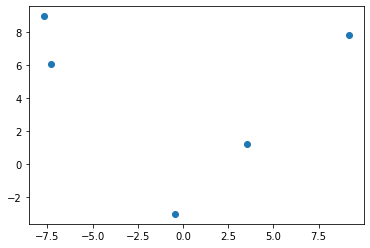


Covariance is positive definite.
(1000, 2)


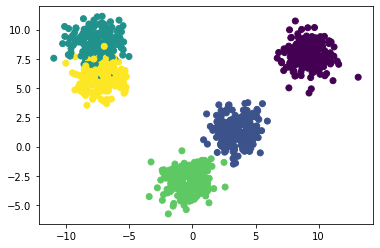

In [168]:
sample_blobs = sample_random_balls(5, var_x = 1, var_y = 1, var_xy = 0)
print(sample_blobs.covariance)
plt.figure()
plt.scatter(sample_blobs.mu[:, 0], sample_blobs.mu[:, 1])
plt.show()

x, l = sample_blobs.sample(1000)

print(x.shape)

plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()

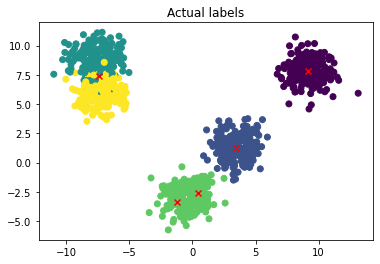

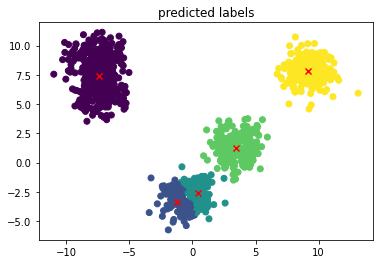

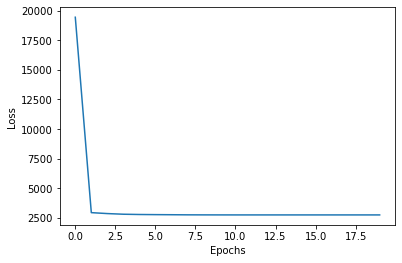

In [169]:
k_means_local = k_means(5, 'random', max_iter = 20)
k_means_local.fit(x)
labels = k_means_local.predict(x)

plt.figure()
plt.title("Actual labels")
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.title("predicted labels")
plt.scatter(x[:, 0], x[:, 1], c = labels)
plt.scatter(k_means_local.cluster_centers_[:, 0], k_means_local.cluster_centers_[:, 1], c = "r", marker = "x")
plt.show()

plt.figure()
plt.plot(k_means_local.inertia_train_)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()